In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import functional as F

In [2]:
def load_model():
  weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT   # Load pretrained model with weights
  model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.7)
  model.eval()

  return model, weights.meta["categories"]

In [3]:
def preprocess_image(image_path):
  image = Image.open(image_path).convert("RGB")
  image_tensor = F.to_tensor(image)

  return image, image_tensor

In [4]:
def model_detection(model, image_tensor):
  with torch.no_grad():
    prediction = model([image_tensor])

  print("Model Output")
  print(prediction)

  return prediction[0]

In [14]:
def visualize_detections(image, prediction, category_names):

  #Convert PIL image to numpy array for OpenCV
  image_np = np.array(image)
  image_npc = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

  #Get the prediction components
  boxes = prediction['boxes'].cpu().numpy().astype(np.int32)
  scores = prediction['scores'].cpu().numpy()
  labels = prediction['labels'].cpu().numpy()

  #Create a copy of the image to draw on
  image_with_boxes = image_npc.copy()

  #Define color map (for different colors)
  color_map = {}

  #Define color map for different classes
  for box, score, label in zip(boxes, scores, labels):
    #Get color for each class
    if label not in color_map:
      color_map[label] = (
          np.random.randint(0, 255),
          np.random.randint(0, 255),
          np.random.randint(0, 255)
      )

    color = color_map[label]

    #Draw bounding box (scratch mode)
    cv2.rectangle(image_with_boxes, (box[0], box[1]), (box[2], box[3]), color, 2)

    #Create label text
    label_text = f"{category_names[label]}: {score:.2f}"
    #Get text size and baseline
    text_size, baseline = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    print(text_size)

    #Draw label background
    cv2.rectangle(
        image_with_boxes,
        (box[0], box[1] - text_size[1] - 5),
        (box[0] + text_size[0], box[1]),
        color,
        -1
    )

    #Draw label text
    cv2.putText(
        image_with_boxes,
        label_text,
        (box[0], box[1] - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255,255,255),
        1,
        cv2.LINE_AA
    )

  #Convert back to RGB for matplotlib
  image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

  return image_with_boxes

In [15]:
def main(image_path):
  #Load model and categories
  model, categories = load_model()
  print(f"Model loaded with {len(categories)} categories")

  #Load and preprocess image
  image, image_tensor = preprocess_image(image_path)

  #Run Detection
  prediction = model_detection(model, image_tensor)

  #Get Detection counts
  num_detections = len(prediction['boxes'])
  print(f"Detected {num_detections} objects")

  #Visualize results
  result_image = visualize_detections(image, prediction, categories)

  plt.figure(figsize=(12,8))
  plt.imshow(result_image)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

  print("Detection Details:")
  for i in range(num_detections):
    box = prediction['boxes'][i].cpu().numpy().astype(np.int32)
    score = prediction['scores'][i].cpu().numpy()
    label = prediction['labels'][i].cpu().numpy()
    print(f"Object {i+1}: {categories[label]}, Score: {score:.2f}, Box: {box}")

  return result_image

Model loaded with 91 categories
Model Output
[{'boxes': tensor([[312.8059, 175.8668, 543.8325, 412.0466],
        [128.9994, 165.5466, 338.4827, 373.8524],
        [207.6648, 102.6043, 278.5175, 284.9142],
        [403.0229,  96.0048, 476.2857, 313.9638]]), 'labels': tensor([19, 19,  1,  1]), 'scores': tensor([0.9996, 0.9990, 0.9985, 0.9985])}]
Detected 4 objects
(92, 12)
(92, 12)
(102, 12)
(102, 12)


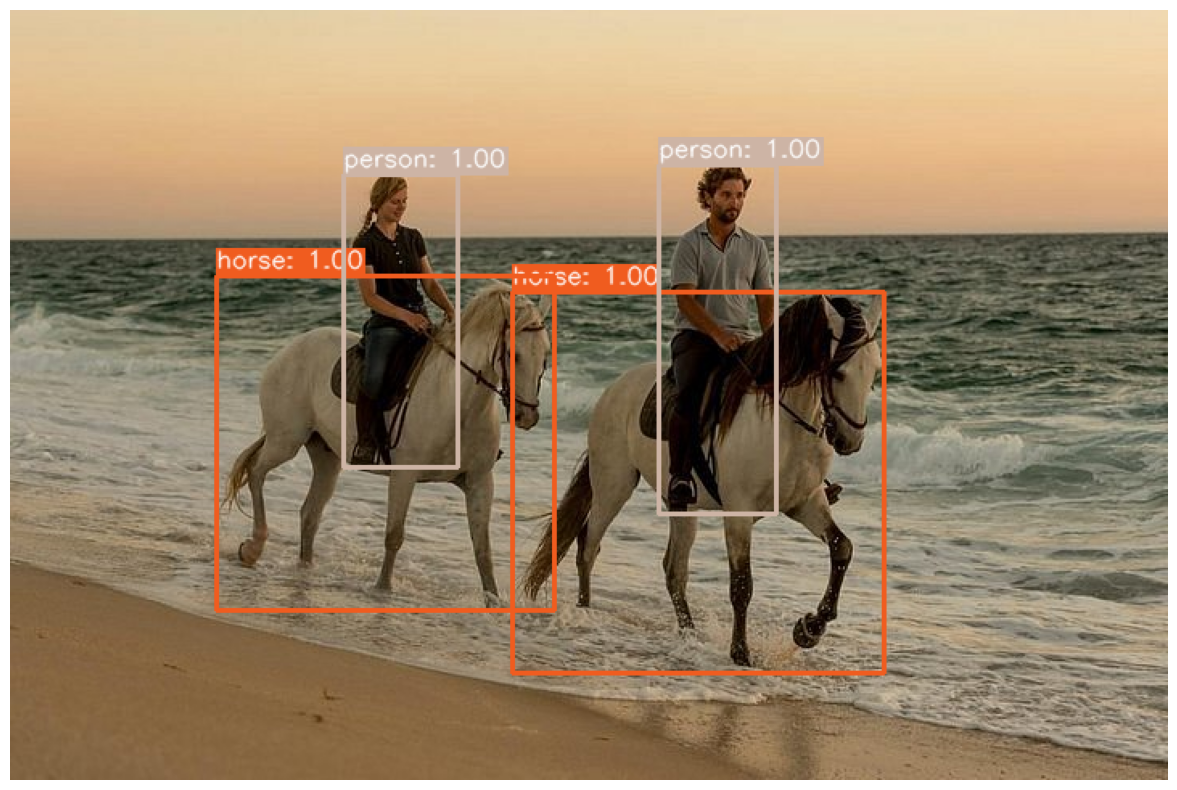

Detection Details:
Object 1: horse, Score: 1.00, Box: [312 175 543 412]
Object 2: horse, Score: 1.00, Box: [128 165 338 373]
Object 3: person, Score: 1.00, Box: [207 102 278 284]
Object 4: person, Score: 1.00, Box: [403  96 476 313]


In [16]:
image_path = "/content/caption.jpg" #or whatever ..
result = main(image_path)